# 고금계 과제 1

20249433 최재필

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [293]:
CWD = Path('.').resolve()
DATA_DIR = CWD / 'data'

In [294]:
from fndata import FnStockData
from fndata import FnMarketData

## Load data

In [295]:
fndata_path = DATA_DIR / '고금계과제1_v3.3_201301-202408.csv'
fnmkt_path = DATA_DIR / '고금계과제_시장수익률_201301-202408.csv'
rf_path = DATA_DIR / '통안채1년물_월평균_201301-202408.csv'

In [296]:
END_DATE = '2023-12-31'

### 주식 데이터

In [297]:
# 데이터 모듈을 생성하며 기본 전처리들을 수행합니다.
fn = FnStockData(fndata_path)

In [298]:
# 사용 가능한 데이터를 확인합니다.
fn_items = fn.get_items()
fn_items

array(['종가(원)', '수정계수', '수정주가(원)', '수익률 (1개월)(%)', 'FnGuide Sector',
       '거래정지여부', '관리종목여부', '보통주자본금(천원)', '자본잉여금(천원)', '이익잉여금(천원)',
       '자기주식(천원)', '이연법인세부채(천원)', '매출액(천원)', '매출원가(천원)', '이자비용(천원)',
       '영업이익(천원)', '총자산(천원)', '기말발행주식수 (보통)(주)'], dtype=object)

In [299]:
# 분석 기간의 데이터 유니버스를 확인합니다. (금융업종, 거래정지, 관리종목 제외)
univ_list = fn.get_universe()
univ_list

array(['A000020', 'A000040', 'A000050', ..., 'A001260', 'A019660',
       'A023460'], dtype=object)

In [300]:
# long format (전부)

df = fn.get_data()
df.head()

Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)     영업이익(천원)  이연법인세부채(천원)    이익잉여금(천원)  \
date       Symbol                                                          
2013-01-31 A000020   1.0   6030.0    2062220.0          0.0  170147330.0   
           A000040   1.0   8727.0   -3486600.0    7181340.0    1298918.0   
           A000050   1.0   7874.0   36031739.0   90652345.0  612310562.0   
           A000070   1.0  67800.0    2472122.0  110818108.0  871019983.0   
           A000080   1.0  32000.0  161051461.0   23405084.0  422540903.0   

Item Name             이자비용(천원)     자기주식(천원)    자본잉여금(천원)    종가(원)  \
date       Symbol                                                   
2013-01-31 A000020    384335.0          0.0   26919758.0   6030.0   
           A000040    813333.0      -5044.0    3884892.0    495.0   
           A000050  13944625.0          0.0   13991400.0  86500.0   
           A000070  17176000.0   -9982000.0  355855971.0  67800.0   
           A000080  56438096.0 -122693570.0  709299321.0  32000.0   

Item Name                총자산(천원)  
date       Symbol                 
2013-01-31 A000020  3.161655e+08  
           A000040  1.169316e+08  
           A000050  1.296989e+09  
           A000070  2.595068e+09  
           A000080  3.553147e+09

In [301]:
# wide format

monthly_returns = fn.get_data('수익률 (1개월)(%)')
monthly_returns = monthly_returns.loc[:END_DATE, :]
monthly_returns.head()

Symbol,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,...,A014940,A053810,A007390,A002410,A037950,A038880,A015020,A001260,A019660,A023460
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,-0.0017,0.0020,-0.0346,-0.0451,0.0526,0.0607,0.1940,-0.0122,-0.0039,-0.0559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,0.0033,-0.0470,0.0537,0.0251,0.0791,-0.0028,-0.0295,-0.0414,0.0078,0.0520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,0.0133,-0.0064,0.0288,0.0187,-0.0073,0.0700,-0.1452,0.0432,0.0039,0.1621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,0.1047,0.0000,0.2594,0.3239,-0.0473,0.0995,0.0783,-0.1302,-0.0502,0.0946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,0.0267,0.0475,0.1667,-0.0598,-0.0140,-0.1167,-0.0283,-0.0238,0.1545,0.0367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [302]:
close = fn.get_data('종가(원)')
close = close.loc[:END_DATE, :]

close.isnull().sum().sum() , monthly_returns.isnull().sum().sum()

# monthly return이 close보다 결측치가 많음. 
# 보수적으로 잡기 위해 결측치가 많은 monthly_return을 기준으로 universe mask를 만들겠다. 

(95306, 96153)

In [303]:
pd.set_option('future.no_silent_downcasting', True)

univ_mask_df = monthly_returns.notnull()
univ_mask_df = univ_mask_df.replace({True: 1, False: np.nan}).astype(float) # mask universe nan where firm doesn't exist.

# C:\Users\chlje\AppData\Local\Temp\ipykernel_16008\3440262636.py:2: 
# FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 
# To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. 
# To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


### 시장 데이터

In [304]:
# 데이터 모듈을 생성하며 기본 전처리들을 수행합니다.
fnmkt = FnMarketData(fnmkt_path)

In [305]:
mkt = fnmkt.get_data(format='wide')
mkt = mkt.loc[:END_DATE, :]

mkf2000 = mkt['MKF2000']
krx300 = mkt['KRX 300']

### 무위험 이자율

In [306]:
rf = pd.read_csv(rf_path)
rf.columns = ['date', 'rf']
rf.set_index('date', inplace=True)
rf.index = pd.to_datetime(rf.index, format='%Y/%m') + pd.offsets.MonthEnd(0)

In [307]:
rf_m = (1 + rf / 100) ** (1 / 12) - 1 # 월율화
rf_m = rf_m.loc[:END_DATE, :]
rf_m.head()

,rf
date,
2013-01-31,0.002239
2013-02-28,0.002214
2013-03-31,0.002149
2013-04-30,0.002125
2013-05-31,0.002125


### 개별 주식들의 excess return

In [308]:
monthly_excess_returns = monthly_returns.sub(rf_m['rf'], axis=0)

## 팩터 데이터 생성

2d wide format을 이용

### 0. 시장초과수익률

In [309]:
# FF_excess_returns = krx300.sub(rf_m['rf'], axis=0) 
FF_excess_returns = mkf2000.sub(rf_m['rf'], axis=0) 

### 1. Mkt Cap

= 기업규모 = 시장가치 = 시가총액 = 보통주 주가 * 발행주식수

In [310]:
raw_close = fn.get_data('종가(원)')
close = raw_close.loc[:END_DATE, :]
close = close * univ_mask_df

common_shares_outstanding = fn.get_data('기말발행주식수 (보통)(주)') 
common_shares_outstanding = common_shares_outstanding.loc[:END_DATE, :]
common_shares_outstanding = common_shares_outstanding * univ_mask_df

In [311]:
F_size = raw_close * common_shares_outstanding

### 2. B/M

자기자본 장부가치 / 시장가치

#### 주의: 재무 데이터 shift 

- t-1년 12월말 측정된 재무제표를 사용해 t년 6월말 포트폴리오를 구성하며, 이는 t년 7월 ~ t+1월 6월까지 사용되고 t+1년 6월말에 재구축됨. 
- 현재 t-1년 12월말 재무제표가 t년 1월~12월까지 ffill(및 bfill)되어있으므로 추가적으로 .shift(6)을 시켜줘야 함. |

#### 2.1 Book 계산

= 자기자본 장부가치 = t-1년 12월말 보통주 자본금 + 자본잉여금 + 이익잉여금 + 자기주식 + 이연법인세 부채

** 장부가치 음수인 자본잠식 상태의 기업들 분석에서 제외

In [312]:
common_stock = fn.get_data('보통주자본금(천원)') # 천원단위 아님
capital_surplus = fn.get_data('자본잉여금(천원)')
retained_earnings = fn.get_data('이익잉여금(천원)')
treasury_stock = fn.get_data('자기주식(천원)')
deferred_tax_liabilities = fn.get_data('이연법인세부채(천원)')

common_stock = common_stock.loc[:END_DATE, :]
capital_surplus = capital_surplus.loc[:END_DATE, :]
retained_earnings = retained_earnings.loc[:END_DATE, :]
treasury_stock = treasury_stock.loc[:END_DATE, :]
deferred_tax_liabilities = deferred_tax_liabilities.loc[:END_DATE, :]

common_stock = common_stock * univ_mask_df
capital_surplus = capital_surplus * univ_mask_df
retained_earnings = retained_earnings * univ_mask_df
treasury_stock = treasury_stock * univ_mask_df
deferred_tax_liabilities = deferred_tax_liabilities * univ_mask_df

common_stock = common_stock.shift(6)
capital_surplus = capital_surplus.shift(6)
retained_earnings = retained_earnings.shift(6)
treasury_stock = treasury_stock.shift(6)
deferred_tax_liabilities = deferred_tax_liabilities.shift(6)

******** 발견한 것: 

재무데이터와 `monthly_return` shape이 다르다. 

재무데이터는 6월30일까지만 불러와져 있다. 그것이 재무제표 업데이트하는 시점인 듯. 

****

재무데이터 에프앤가이드에서 이미 t-1시점 값으로 제공. 

In [313]:
# # t-1년도의 값으로 ffill 

# eoy = (common_stock.index.month == 12)

# common_stock = common_stock.loc[eoy, :].reindex(
#     index=common_stock.index, method='ffill'
# )

# capital_surplus = capital_surplus.loc[eoy, :].reindex(
#     index=capital_surplus.index, method='ffill'
# )

# retained_earnings = retained_earnings.loc[eoy, :].reindex(
#     index=retained_earnings.index, method='ffill'
# )

# treasury_stock = treasury_stock.loc[eoy, :].reindex(
#     index=treasury_stock.index, method='ffill'
# )

# deferred_tax_liabilities = deferred_tax_liabilities.loc[eoy, :].reindex(
#     index=deferred_tax_liabilities.index, method='ffill'
# )

In [314]:
# common_stock = common_stock.fillna(0) # 없으면 drop 

capital_surplus = capital_surplus.fillna(0)
retained_earnings = retained_earnings.fillna(0)
treasury_stock = treasury_stock.fillna(0)
deferred_tax_liabilities = deferred_tax_liabilities.fillna(0)

In [315]:
# fillna(0) 없이 처리하면 하나라도 nan이면 모두 nan으로 처리됨

book_equity = common_stock + capital_surplus + retained_earnings + treasury_stock + deferred_tax_liabilities

****

book equity = common stock + capital surplus + retained earnings + treasury stock + deferred tax liabilities 맞음. 

treasury stock 의 경우 -로 report 되기 때문. 

비율이기 때문에 시가총액의 기준도 같이 봐야 하는데, 시가총액 역시 자사보유주를 제외하지 않은 그냥 outstanding stock이기 때문에 BE에도 treasury stock을 포함하는 것이 맞음. 

#### 2.2 B/M 계산

In [316]:
mkt_cap_12 = F_size.loc[F_size.index.month == 12, :].reindex(
    index=common_stock.index, method='ffill'
) 
mkt_cap_12 = mkt_cap_12 * univ_mask_df

# market cap은 재무데이터가 아니라 가장 최근 9월까지도 다 채워져있음.
# 재무데이터 길이와 맞추도록 reindex 후 ffill


In [317]:
F_bm = book_equity / mkt_cap_12

### 3. 수익성

= Operating Profit / Equity 

Quality 팩터

### 3.1 Operating Profit

= t-1년 12월 말의 매출액 - 매출원가 - 이자비용 - 판매및관리비 차감한 

영업이익 

In [318]:
# sales_revenue = fn.get_data('매출액(천원)')
# cost_of_goods_sold = fn.get_data('매출원가(천원)')
# interest_expense = fn.get_data('이자비용(천원)')

operating_profit = fn.get_data('영업이익(천원)')
operating_profit = operating_profit.loc[:END_DATE, :]
operating_profit = operating_profit * univ_mask_df
operating_profit = operating_profit.shift(6)

********** 매출액조차 분기별로 변하지 않고 연간으로 변한다.

이것도 이미 작년 12월 값으로 ffill 된 것 같음. 별도 처리 필요 x 

#### 3.2 수익성 계산

Operating Profit, Equity 둘 다 t-1년 12월 말 기준

In [319]:
F_quality = operating_profit / book_equity

### 4. 자본투자

= (t-1년 12월 총자산 - t-2년 12월 총자산) / t-2년 12월 총자산 = 즉, 총자산의 증가율

In [320]:
total_asset = fn.get_data('총자산(천원)')
total_asset = total_asset.loc[:END_DATE, :]
total_asset = total_asset * univ_mask_df
total_asset = total_asset.shift(6)

In [321]:
F_inv = (total_asset - total_asset.shift(12)) / total_asset.shift(12)

### 5. UMD

= Up Minus Down = (전월말 주가 - 1년전 월말 주가 ) / 1년전 월말 주가

** 모멘텀의 경우 1개월마다 리밸런싱, 상위 30%가 winner / 하위 30%가 loser

In [322]:
adj_close = fn.get_data('수정주가(원)')
adj_close = adj_close.loc[:END_DATE, :]
adj_close = adj_close * univ_mask_df

In [323]:
F_umd = (adj_close.shift(1) - adj_close.shift(12)) / adj_close.shift(12)

### 6. STR

= short term reversal 

- 추후 회귀할 때 계수의 방향에 주의

In [324]:
F_str = monthly_returns.shift(1).copy()

## 팩터 포트폴리오 생성

### 팩터 class 생성

- 팩터 2d dataframe을 1개 입력받아 팩터를 만들 수 있도록 팩터 포트폴리오 class 생성
    - cross sectional로 XMY 나눠주는 기능
        - 분위에 따라 1, 2, 3 , ... 이런 식으로 (ascending)
        - 분위와 포폴(X, XMY, Y)을 입력받아 univ boolean df를 return하는 기능
    - 이를 기반으로 X포트폴리오와 Y포트폴리오 만드는 기능
        - weighting scheme: ew, vw 고를 수 있게 하기
        - rebalancing 주기/날짜 고를 수 있게 하기
    - XMY, X, Y 포트폴리오의 수익률 및 기타 성과 매트릭을 뽑을 수 있는 기능
    - 이를 플롯할 수 있는 기능
- 팩터 포트폴리오 instance를 2개 입력받아 independent sort 결과 보여주는 class 생성
    - n분위 * m분위의 mini portfolio들을 만들어내는 기능
    - 이를 다시 팩터 포트폴리오 instance로 만들어내는 기능
    - 미니 포트폴리오 instance들을 사용하여 성과 매트릭을 뽑아주는 기능
        - index축 포폴1, column축 포폴2로 기간(입력받아) 선택한 매트릭의 평균/max/min 등을 뽑아주는 기능
        - index축 time, column축 (포폴1, 포폴2)로 선택한 매트릭의 평균/max/min 등을 뽑아주는 기능
    - 성과 매트릭이 아닌 원본 데이터값도 뽑을 수 있게 하기 
        - 미니 포트폴리오의 univ를 뽑아서 입력받은 원본 데이터 df에 masking시켜 테이블 형태로 반환
        - 즉, 테이블을 뽑는 것은 instance 자체와 couple되어있으면 안됨. 
    - 최종 포폴 수익률 뽑는 기능
        - 이 땐 1/3, 1/2 시나리오만 만들어서 구하는걸로. 애초에 SingleFactorPortfolio의 n_groups가 2 또는 3인 것들만 받아야 함. 
        - 포폴1, 포폴2를 각각 return할 수 있어야 함. 

In [352]:
class FactorUniv:
    def __init__(
            self, 
            factor_df: pd.DataFrame, 
            n_groups: int, 
            ) -> None:
        self.factor_df = factor_df
        self.n_groups = n_groups

        self._reload()
        
    def _reload(self):
        self._qcut = self._return_qcut()
        self.low_univ = self.get_qcut_univ(1)
        self.high_univ = self.get_qcut_univ(self.n_groups)

    def set_n_groups(self, n_groups: int):
        self.n_groups = n_groups
        self._reload()

    def _return_qcut(self,):
        qcut = self.factor_df.apply(
            lambda row: pd.qcut(row, self.n_groups, labels=False, duplicates='drop') + 1, # qcut can fail if there are duplicates or all nans --> then fill with nan
            axis=1
        )

        return qcut
    
    def get_qcut_univ(self, q: int):
        assert q in range(1, self.n_groups + 1)

        return ( self._qcut == q )
    
    def __repr__(self) -> str:
        meta = {
            'factor_df': self.factor_df.shape,
            'start_date': self.factor_df.index[0],
            'end_date': self.factor_df.index[-1],

            'n_groups': self.n_groups,
        }

        return str(meta)

In [366]:
class Portfolio:
    def __init__(
            self, 
            univ_df: pd.DataFrame,
            returns_df: pd.DataFrame,
            mktcap_df: pd.DataFrame = None,
            weighting: str = 'ew',
            rebalancing: str = 'monthly',
            ) -> None:
        self.univ_df = univ_df
        self.holding_df = univ_df.copy()
        self.returns_df = returns_df.shift(-1) # shift -1 month to avoid look-ahead bias
        self.mktcap_df = mktcap_df
        
        self.set_weighting(weighting, reload=False)
        self.set_rebalancing(rebalancing, reload=False)

        self._reload()
    
    def _reload(self):
        self._compute_port_returns_df()
        self._port_returns = self._port_returns_df.sum(axis=1)
        self._compute_ts_nobs()

    def set_weighting(self, weighting: str, reload: bool = True):
        assert weighting in ['ew', 'vw'], 'weighting must be ew or vw'
        if weighting == 'vw':
            assert self.mktcap_df is not None, 'mktcap_df must be provided for vw weighting'
        
        self.weighting = weighting

        if reload:
            self._reload()
    
    def set_rebalancing(self, rebalancing: str, reload: bool = True):
        assert rebalancing in ['monthly', 'quarterly', 'annual'], 'rebalancing must be monthly, quarterly, or annual'
        
        self.rebalancing = rebalancing

        if self.rebalancing == 'monthly':
            pass
        elif self.rebalancing == 'quarterly':
            self.holding_df = self.univ_df.resample('Q').last()
            self.holding_df = self.holding_df.reindex(self.univ_df.index, method='ffill').astype(bool)
            self.holding_df = self.holding_df * self.univ_df
        elif self.rebalancing == 'annual':
            self.holding_df = self.univ_df.resample('YE-JUN').last() # Year End June
            self.holding_df = self.holding_df.reindex(self.univ_df.index, method='ffill').astype(bool)
            self.holding_df = self.holding_df * self.univ_df

        if reload:
            self._reload()

    def _compute_port_returns_df(self):

        # Some market caps are 0, leading to zero division error.
        self.mktcap_df = self.mktcap_df.replace(0, np.nan)

        if self.weighting == 'ew':
            weighted_returns_df = self.returns_df[self.holding_df].div( self.holding_df.sum(axis=1), axis=0 , fill_value=None)
        elif self.weighting == 'vw':
            weighted_returns_df = ( (self.returns_df[self.holding_df] * self.mktcap_df[self.holding_df]) ).div( self.mktcap_df[self.holding_df].sum(axis=1), axis=0 , fill_value=None)

        self._port_returns_df = weighted_returns_df
    
    # def _compute_ts_stats(self):
    #     # TODO: Add more stats, like Sharpe, Sortino, etc.
    #     pass

    def _compute_ts_nobs(self):
        self._ts_nobs = self.holding_df.sum(axis=1)

    @property
    def port_ts_nobs(self):
        return self._ts_nobs
    
    @property
    def port_returns_df(self):
        # TODO: Apply rebalancing
        return self._port_returns_df
    
    @property
    def port_returns(self):
        return self._port_returns
    
    def get_avg_factor(self, factor_df: pd.DataFrame):
        return factor_df[self.holding_df].mean(axis=1)
    
    def __repr__(self) -> str:
        meta = {
            'univ_df': self.univ_df.shape,
            'start_date': self.univ_df.index[0],
            'end_date': self.univ_df.index[-1],

            'weighting': self.weighting,
            'rebalancing': self.rebalancing,
        }

        return str(meta)

In [327]:
class DoubleIndependentFactor:
    def __init__(
            self, 
            factor_univ_1: FactorUniv,
            factor_univ_2: FactorUniv,

            returns_df: pd.DataFrame,
            mktcap_df: pd.DataFrame = None,
            weighting: str = 'ew',
            rebalancing: str = 'monthly',
            ) -> None:

        self.factor_univ_1 = factor_univ_1 
        self.factor_univ_2 = factor_univ_2

        self.returns_df = returns_df
        self.mktcap_df = mktcap_df
        self.weighting = weighting 
        self.rebalancing = rebalancing

        self._combine_univs()
        self._create_mini_portfolios()
        # self._create_factor_returns()
    
    def _combine_univs(self):
        # Combine two factor universes
        f1_subunivs = [self.factor_univ_1.get_qcut_univ(q) for q in range(1, self.factor_univ_1.n_groups + 1)]
        f2_subunivs = [self.factor_univ_2.get_qcut_univ(q) for q in range(1, self.factor_univ_2.n_groups + 1)]

        self._univ_combinations = [
            (i1+1, i2+1, f1 & f2) for f1, i1 in enumerate(f1_subunivs) for f2, i2 in enumerate(f2_subunivs)
        ]
    
    @property
    def univ_combinations(self):
        return self._univ_combinations

    def _create_mini_portfolios(self):
        self._mini_portfolios = [
            (i1, i2, Portfolio(univ_df, self.returns_df, self.mktcap_df, self.weighting, self.rebalancing)) 
            for i1, i2, univ_df in self._univ_combinations
        ]

    @property
    def mini_portfolios(self):
        return self._mini_portfolios
    
    def __repr__(self) -> str:
        meta = {
            'factor_univ_1': self.factor_univ_1,
            'factor_univ_2': self.factor_univ_2,

            'returns_df': self.returns_df.shape,
            'start_date': self.returns_df.index[0],
            'end_date': self.returns_df.index[-1],

            'mktcap_df': self.mktcap_df.shape if self.mktcap_df is not None else None,
            'weighting': self.weighting,
            'rebalancing': self.rebalancing,
        }

        return str(meta)


In [328]:
class XMY:
    def __init__( 
            self, 
            size_univ: FactorUniv, # size
            factor_univ: FactorUniv, # factor

            returns_df: pd.DataFrame,
            mktcap_df: pd.DataFrame = None,
            weighting: str = 'ew',
            rebalancing: str = 'monthly',
            ) -> None:
        
        assert size_univ.n_groups == 2, 'size_univ must have 2 groups'
        assert factor_univ.n_groups == 2, 'factor_univ must have 2 groups'

        self.size_univ = size_univ
        self.factor_univ = factor_univ

        self.return_df = returns_df
        self.mktcap_df = mktcap_df
        self.weighting = weighting
        self.rebalancing = rebalancing

        self.DIS = DoubleIndependentFactor(self.size_univ, self.factor_univ, self.return_df, self.mktcap_df, self.weighting, self.rebalancing)
        self._mini_portfolios = self.DIS.mini_portfolios

        self._create_factor_returns()
    
    def _create_factor_returns(self):
        mini_port_returns = [ (i1, i2, mini_port._port_returns) for i1, i2, mini_port in self._mini_portfolios]

        # f1 (size)
        self.f1_high = np.mean([ port_return for i1, _, port_return in mini_port_returns if i1 == self.size_univ.n_groups ]) 
        self.f1_low = np.mean([ port_return for i1, _, port_return in mini_port_returns if i1 == 1 ])
        self.f1_hml = self.f1_high - self.f1_low

        # f2 (factor)
        self.f2_high = np.mean([ port_return for _, i2, port_return in mini_port_returns if i2 == self.factor_univ.n_groups ])
        self.f2_low = np.mean([ port_return for _, i2, port_return in mini_port_returns if i2 == 1 ])
        self.f2_hml = self.f2_high - self.f2_low

In [329]:
class SMB:
    def __init__( 
            self, 
            size_univ: FactorUniv, # size 
            factor_univ_1: FactorUniv, # B/M
            factor_univ_2: FactorUniv, # OP
            factor_univ_3: FactorUniv, # INV

            returns_df: pd.DataFrame,
            mktcap_df: pd.DataFrame = None,
            weighting: str = 'ew',
            rebalancing: str = 'monthly',
            ) -> None:
        
        assert size_univ.n_groups == 2, 'size_univ must have 2 groups'
        assert factor_univ_1.n_groups == 3, 'factor_univ_1 must have 3 groups' 
        assert factor_univ_2.n_groups == 3, 'factor_univ_2 must have 3 groups' 
        assert factor_univ_3.n_groups == 3, 'factor_univ_3 must have 3 groups' 

        self.size_univ = size_univ
        self.factor_univ_1 = factor_univ_1
        self.factor_univ_2 = factor_univ_2
        self.factor_univ_3 = factor_univ_3

        self.return_df = returns_df
        self.mktcap_df = mktcap_df
        self.weighting = weighting
        self.rebalancing = rebalancing

        self.DIS1 = DoubleIndependentFactor(self.size_univ, self.factor_univ_1, self.return_df, self.mktcap_df, self.weighting, self.rebalancing)
        self._mini_portfolios1 = self.DIS1.mini_portfolios

        self.DIS2 = DoubleIndependentFactor(self.size_univ, self.factor_univ_2, self.return_df, self.mktcap_df, self.weighting, self.rebalancing)
        self._mini_portfolios2 = self.DIS2.mini_portfolios

        self.DIS3 = DoubleIndependentFactor(self.size_univ, self.factor_univ_3, self.return_df, self.mktcap_df, self.weighting, self.rebalancing)
        self._mini_portfolios3 = self.DIS3.mini_portfolios

        self._create_factor_returns()
    
    def _create_SMB_returns(self):
        factor1_mini_port_returns = [ (i1, i2, mini_port._port_returns) for i1, i2, mini_port in self._mini_portfolios1] # note that i2 is the factor. i1 is the size.
        factor2_mini_port_returns = [ (i1, i2, mini_port._port_returns) for i1, i2, mini_port in self._mini_portfolios2]
        factor3_mini_port_returns = [ (i1, i2, mini_port._port_returns) for i1, i2, mini_port in self._mini_portfolios3]

        # SMB B/M
        self.SMB1_low = np.mean([ port_return for i1, _, port_return in factor1_mini_port_returns if i1 == 1 ])
        self.SMB1_high = np.mean([ port_return for i1, _, port_return in factor1_mini_port_returns if i1 == 2 ])
        self.SMB1 = self.SMB1_low - self.SMB1_high

        # SMB OP
        self.SMB2_low = np.mean([ port_return for i1, _, port_return in factor2_mini_port_returns if i1 == 1 ])
        self.SMB2_high = np.mean([ port_return for i1, _, port_return in factor2_mini_port_returns if i1 == 2 ])
        self.SMB2 = self.SMB2_low - self.SMB2_high

        # SMB INV
        self.SMB3_low = np.mean([ port_return for i1, _, port_return in factor3_mini_port_returns if i1 == 1 ])
        self.SMB3_high = np.mean([ port_return for i1, _, port_return in factor3_mini_port_returns if i1 == 2 ])
        self.SMB3 = self.SMB3_low - self.SMB3_high

        self.SMB = (self.SMB1 + self.SMB2 + self.SMB3) / 3

### 팩터 수익률 계산

In [367]:
F_bm_univ = FactorUniv(F_bm, 5)
F_size_univ = FactorUniv(F_size, 5)

In [376]:
F_bm_low_port_vw = Portfolio(F_bm_univ.low_univ, monthly_excess_returns, F_size, 'vw', 'annual')
# F_bm_low_port_vw = Portfolio(F_bm_univ.low_univ, monthly_excess_returns, F_size, 'vw', 'monthly')
F_bm_high_port_vw = Portfolio(F_bm_univ.high_univ, monthly_excess_returns, F_size, 'vw', 'monthly')

F_size_low_port_vw = Portfolio(F_size_univ.low_univ, monthly_excess_returns, F_size, 'vw', 'monthly')
F_size_high_port_vw = Portfolio(F_size_univ.high_univ, monthly_excess_returns, F_size, 'vw', 'monthly')

In [374]:
F_bm_low_port_ew = Portfolio(F_bm_univ.low_univ, monthly_excess_returns, F_size, 'ew', 'monthly')
F_bm_high_port_ew = Portfolio(F_bm_univ.high_univ, monthly_excess_returns, F_size, 'ew', 'monthly')

F_size_low_port_ew = Portfolio(F_size_univ.low_univ, monthly_excess_returns, F_size, 'ew', 'monthly')
F_size_high_port_ew = Portfolio(F_size_univ.high_univ, monthly_excess_returns, F_size, 'ew', 'monthly')


<Axes: xlabel='date'>

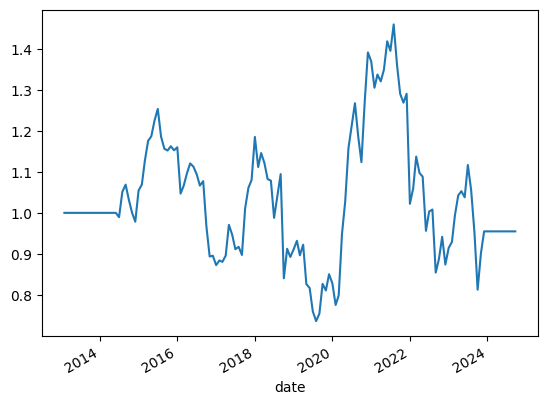

In [377]:
(F_bm_low_port_vw.port_returns + 1).cumprod().plot()

### Size-B/M 포트폴리오

- Size, B/M으로 double sort

In [378]:
DIS_size_bm = DoubleIndependentFactor(F_size_univ, F_bm_univ, monthly_excess_returns, F_size, 'vw', 'monthly')

AttributeError: 'int' object has no attribute 'copy'

## Devil's in HML's detail 

- Asness의 주장대로 B/M 계산시 B는 작년 12월을 쓰더라도 M은 최근 6월 주가를 사용
- 변경된 B/M 포트폴리오를 통해 결과 재산출